In [2]:
pip install 'shimmy>=2.0'

In [3]:
pip install textblob vaderSentiment transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.5 MB/s eta 0:00:00


In [5]:
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [1]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.7 MB/s eta 0:00:00


In [2]:
from transformers import pipeline
import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import stable_baselines3 as sb3
import requests
from stable_baselines3.common.vec_env import DummyVecEnv
import mplfinance as mpf
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gym
from gym import spaces

***MAIN MODEL***

In [ ]:


sentiment_pipeline = pipeline("sentiment-analysis")

def analyze_sentiment_transformers(news_articles):
    sentiments = []
    for article in news_articles:
        sentiment = sentiment_pipeline(article['title'])
        sentiments.append({
            'article': article['title'],
            'sentiment': sentiment[0]['label'],
            'confidence': sentiment[0]['score']
        })
    return sentiments

class MarketData:
    def __init__(self, tickers, start, end):
        self.tickers = tickers
        self.start = start
        self.end = end

    def fetch_data(self):
        data = yf.download(self.tickers, start=self.start, end=self.end)
        if data.empty or data.isna().all().all():
            raise ValueError("No valid data fetched. Check ticker symbols and date range.")
        data = data.dropna()
        data.columns = ['_'.join(col) for col in data.columns]
        return data

class AlphaFactors:
    def __init__(self, data):
        self.data = data

    def extract_features(self):
        close_prices = self.data.filter(like='Close')
        returns = close_prices.pct_change().dropna()

        if returns.empty or returns.isna().all().all():
            raise ValueError("No valid data available for feature extraction.")

        returns = StandardScaler().fit_transform(returns)
        n_components = min(returns.shape[0], returns.shape[1], 3)

        if n_components == 0:
            raise ValueError("Insufficient data for PCA. Check the input dataset.")

        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(returns)
        return pd.DataFrame(principal_components)

class TradingEnv(gym.Env):
    def __init__(self, data, sentiment_data=None, econ_data=None):
        super(TradingEnv, self).__init__()
        self.data = data
        self.sentiment_data = sentiment_data
        self.econ_data = econ_data

        if len(self.sentiment_data) < len(self.data):
            self.sentiment_data = np.interp(
                np.linspace(0, 1, len(self.data)),
                np.linspace(0, 1, len(self.sentiment_data)),
                self.sentiment_data
            ).tolist()

        if len(self.econ_data) < len(self.data):
            self.econ_data = np.interp(
                np.linspace(0, 1, len(self.data)),
                np.linspace(0, 1, len(self.econ_data)),
                self.econ_data
            ).tolist()

        self.current_step = 0
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(data.shape[1] + 2,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(data.shape[1] + 2,), dtype=np.float32)

    def step(self, action):
        profit_loss = np.dot(self.data.iloc[self.current_step], action[:-2])
        rolling_mean = np.mean(self.data.iloc[max(0, self.current_step-10):self.current_step+1].values)
        reward = profit_loss - rolling_mean
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        observation = np.concatenate([self.data.iloc[self.current_step].values, [self.sentiment_data[self.current_step]], [self.econ_data[self.current_step]]])
        return observation, reward, done, {}

    def reset(self):
        self.current_step = 0
        observation = np.concatenate([self.data.iloc[self.current_step].values, [self.sentiment_data[self.current_step]], [self.econ_data[self.current_step]]])
        return observation

# Fetch news articles from News API
def fetch_news_articles(company_name, api_key, page_size=10):
    url = f"https://newsapi.org/v2/everything?q={company_name}&apiKey={api_key}&pageSize={page_size}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()['articles']
    else:
        raise ValueError("Failed to fetch news articles from News API")

if __name__ == "__main__":
    rl_algorithm = input("Choose RL Algorithm - PPO or DDPG: ").strip().upper()

    tickers = ['AAPL', 'GOOGL', 'MSFT']
    market_data = MarketData(tickers, '2020-01-01', '2024-01-01')
    data = market_data.fetch_data()
    alpha_factors = AlphaFactors(data)
    numerical_features = alpha_factors.extract_features().to_numpy()

    company_name = 'Apple'
    api_key = '81de622b12d64124a6c5b7e976e982b2'
    news_articles = fetch_news_articles(company_name, api_key)
    sentiment_results = analyze_sentiment_transformers(news_articles)
    sentiment_data = [result['confidence'] for result in sentiment_results]

    econ_data = pd.read_csv('/content/drive/MyDrive/Global Economy Indicators.csv')
    econ_data.columns = econ_data.columns.str.strip()
    econ_data = econ_data['Gross Domestic Product (GDP)'].values[:len(numerical_features)]

    if len(sentiment_data) < len(numerical_features):
        sentiment_data = np.interp(
            np.linspace(0, 1, len(numerical_features)),
            np.linspace(0, 1, len(sentiment_data)),
            sentiment_data
        ).tolist()

    if len(econ_data) < len(numerical_features):
        econ_data = np.interp(
            np.linspace(0, 1, len(numerical_features)),
            np.linspace(0, 1, len(econ_data)),
            econ_data
        ).tolist()

    env = DummyVecEnv([lambda: TradingEnv(pd.DataFrame(numerical_features), sentiment_data, econ_data)])

    model = sb3.PPO("MlpPolicy", env, verbose=1) if rl_algorithm == "PPO" else sb3.DDPG("MlpPolicy", env, verbose=1)

    model.learn(total_timesteps=10000)
    print("Training complete.")
    model.save("main_trained_trading_model")
    print("Model saved successfully.")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


Choose RL Algorithm - PPO or DDPG: DDPG
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 133       |
|    time_elapsed    | 30        |
|    total_timesteps | 4016      |
| train/             |           |
|    actor_loss      | -1.05e+08 |
|    critic_loss     | 6.13e+15  |
|    learning_rate   | 0.001     |
|    n_updates       | 3915      |
----------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 129      |
|    time_elapsed    | 61       |
|    total_timesteps | 8032     |
| train/             |          |
|    actor_loss      | 5.81e+07 |
|    critic_loss     | 7.53e+15 |
|    learning_rate   | 0.001    |
|    n_updates       | 7931     |
---------------------------------
Training complete.
Model saved successfully.


**MARKET DATA RECONSTRUCTION**

In [ ]:
def fetch_market_data(tickers, start_date='2022-01-01', end_date='2022-12-31'):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data

tickers = ['AAPL', 'GOOGL', 'MSFT']

market_data_df = fetch_market_data(tickers)

print(market_data_df.columns)

market_data_df.columns = ['_'.join(col) for col in market_data_df.columns]

market_data_df = market_data_df.reset_index()

print(market_data_df.head())

def generate_numerical_features(df):
    tickers = ['AAPL', 'GOOGL', 'MSFT']

    for ticker in tickers:
        df[f'SMA_50_{ticker}'] = df[f'Close_{ticker}'].rolling(window=50).mean()
        df[f'SMA_200_{ticker}'] = df[f'Close_{ticker}'].rolling(window=200).mean()
        df[f'RSI_{ticker}'] = compute_rsi(df[f'Close_{ticker}'])
        compute_macd(df, ticker)
        compute_bollinger_bands(df, ticker)
        compute_atr(df, ticker)
        compute_log_returns(df, ticker)
        compute_volatility_and_change(df, ticker)

    df = df.dropna()
    return df

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_macd(df, ticker):
    df[f'MACD_{ticker}'] = df[f'Close_{ticker}'].ewm(span=12, adjust=False).mean() - df[f'Close_{ticker}'].ewm(span=26, adjust=False).mean()
    df[f'MACD_signal_{ticker}'] = df[f'MACD_{ticker}'].ewm(span=9, adjust=False).mean()

def compute_bollinger_bands(df, ticker, window=20):
    df[f'BB_middle_{ticker}'] = df[f'Close_{ticker}'].rolling(window=window).mean()
    df[f'BB_upper_{ticker}'] = df[f'BB_middle_{ticker}'] + (df[f'Close_{ticker}'].rolling(window=window).std() * 2)
    df[f'BB_lower_{ticker}'] = df[f'BB_middle_{ticker}'] - (df[f'Close_{ticker}'].rolling(window=window).std() * 2)

def compute_atr(df, ticker, window=14):
    df[f'H-L_{ticker}'] = df[f'High_{ticker}'] - df[f'Low_{ticker}']
    df[f'H-PC_{ticker}'] = abs(df[f'High_{ticker}'] - df[f'Close_{ticker}'].shift())
    df[f'L-PC_{ticker}'] = abs(df[f'Low_{ticker}'] - df[f'Close_{ticker}'].shift())
    df[f'TR_{ticker}'] = df[[f'H-L_{ticker}', f'H-PC_{ticker}', f'L-PC_{ticker}']].max(axis=1)
    df[f'ATR_{ticker}'] = df[f'TR_{ticker}'].rolling(window=window).mean()

def compute_log_returns(df, ticker):
    df[f'log_returns_{ticker}'] = np.log(df[f'Close_{ticker}'] / df[f'Close_{ticker}'].shift(1))

def compute_volatility_and_change(df, ticker, window=20):
    df[f'returns_{ticker}'] = df[f'Close_{ticker}'].pct_change()
    df[f'volatility_{ticker}'] = df[f'returns_{ticker}'].rolling(window=window).std()
    df[f'price_change_{ticker}'] = df[f'Close_{ticker}'].pct_change() * 100

numerical_features_df = generate_numerical_features(market_data_df)
print(numerical_features_df.head())


[*********************100%***********************]  3 of 3 completed

MultiIndex([( 'Close',  'AAPL'),
            ( 'Close', 'GOOGL'),
            ( 'Close',  'MSFT'),
            (  'High',  'AAPL'),
            (  'High', 'GOOGL'),
            (  'High',  'MSFT'),
            (   'Low',  'AAPL'),
            (   'Low', 'GOOGL'),
            (   'Low',  'MSFT'),
            (  'Open',  'AAPL'),
            (  'Open', 'GOOGL'),
            (  'Open',  'MSFT'),
            ('Volume',  'AAPL'),
            ('Volume', 'GOOGL'),
            ('Volume',  'MSFT')],
           names=['Price', 'Ticker'])
        Date  Close_AAPL  Close_GOOGL  Close_MSFT   High_AAPL  High_GOOGL  \
0 2022-01-03  178.879929   144.301605  325.634735  179.734977  145.157013   
1 2022-01-04  176.609665   143.712433  320.051117  179.793951  145.788005   
2 2022-01-05  171.911835   137.119431  307.764954  177.071549  143.811936   
3 2022-01-06  169.042068   137.092072  305.333130  172.285320  139.274144   
4 2022-01-07  169.209137   136.365051  305.488739  171.145259  137.789743   

   

In [ ]:
market_data_df

,Date,Close_AAPL,Close_GOOGL,Close_MSFT,High_AAPL,High_GOOGL,High_MSFT,Low_AAPL,Low_GOOGL,Low_MSFT,...,BB_lower_MSFT,H-L_MSFT,H-PC_MSFT,L-PC_MSFT,TR_MSFT,ATR_MSFT,log_returns_MSFT,returns_MSFT,volatility_MSFT,price_change_MSFT
0,2022-01-03,178.879929,144.301605,325.634735,179.734977,145.157013,328.796237,174.653889,143.029185,320.800067,...,NaN,7.996170,NaN,NaN,7.996170,NaN,NaN,NaN,NaN,NaN
1,2022-01-04,176.609665,143.712433,320.051117,179.793951,145.788005,326.072567,176.039637,143.032684,317.239797,...,NaN,8.832770,0.437831,8.394938,8.832770,NaN,-0.017296,-0.017147,NaN,-1.714688
2,2022-01-05,171.911835,137.119431,307.764954,177.071549,143.811936,317.191097,171.636651,137.032854,307.375852,...,NaN,9.815245,2.860020,12.675265,12.675265,NaN,-0.039144,-0.038388,NaN,-3.838813
3,2022-01-06,169.042068,137.092072,305.333130,172.285320,139.274144,310.021890,168.688259,135.908734,303.008195,...,NaN,7.013695,2.256936,4.756759,7.013695,NaN,-0.007933,-0.007902,NaN,-0.790156
4,2022-01-07,169.209137,136.365051,305.488739,171.145259,137.789743,307.881745,168.088742,135.120498,301.646285,...,NaN,6.235460,2.548615,3.686845,6.235460,NaN,0.000510,0.000510,NaN,0.050964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2022-12-23,130.344482,88.805435,234.405426,130.898044,89.123912,234.542889,128.149997,86.655709,229.702203,...,230.358007,4.840686,0.667676,4.173011,4.840686,6.793942,0.002265,0.002267,0.021628,0.226707
247,2022-12-27,128.535522,86.974174,232.667496,129.899667,88.516802,234.601796,127.240581,86.595985,231.557961,...,229.529222,3.043835,0.196370,2.847465,3.043835,6.444671,-0.007442,-0.007414,0.021081,-0.741421
248,2022-12-28,124.591377,85.610703,230.281494,129.524023,87.621095,235.377480,124.423333,85.531089,229.928015,...,228.418946,5.449465,2.709984,2.739481,5.449465,6.556887,-0.010308,-0.010255,0.021159,-1.025498
249,2022-12-29,128.120346,88.029129,236.644104,128.980342,88.427227,237.537623,126.261956,86.197888,231.381200,...,228.103339,6.156423,7.256129,1.099706,7.256129,6.676816,0.027255,0.027630,0.016773,2.762971


**PREDICTION AND VISUALIZATION**

[*********************100%***********************]  3 of 3 completed


Number of features: 72
Step 0: Action Scalar = 1.0


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Step 0: Action=1.00 | Signal=BUY | Price=72.72
Step 1: Action Scalar = 1.0
Step 1: Action=1.00 | Signal=HOLD | Price=72.01
Step 2: Action Scalar = 1.0
Step 2: Action=1.00 | Signal=HOLD | Price=72.58
Step 3: Action Scalar = 1.0
Step 3: Action=1.00 | Signal=HOLD | Price=72.24
Step 4: Action Scalar = 1.0
Step 4: Action=1.00 | Signal=HOLD | Price=73.40
Step 5: Action Scalar = 1.0
Step 5: Action=1.00 | Signal=HOLD | Price=74.96
Step 6: Action Scalar = 1.0
Step 6: Action=1.00 | Signal=HOLD | Price=75.13
Step 7: Action Scalar = 1.0
Step 7: Action=1.00 | Signal=SELL (PROFIT: 4.02) | Price=76.74
Step 8: Action Scalar = 1.0
Step 8: Action=1.00 | Signal=BUY | Price=75.70
Step 9: Action Scalar = 1.0
Step 9: Action=1.00 | Signal=HOLD | Price=75.38
Step 10: Action Scalar = 1.0
Step 10: Action=1.00 | Signal=HOLD | Price=76.32
Step 11: Action Scalar = 1.0
Step 11: Action=1.00 | Signal=HOLD | Price=77.17
Step 12: Action Scalar = 1.0
Step 12: Action=1.00 | Signal=HOLD | Price=76.64
Step 13: Action Scala

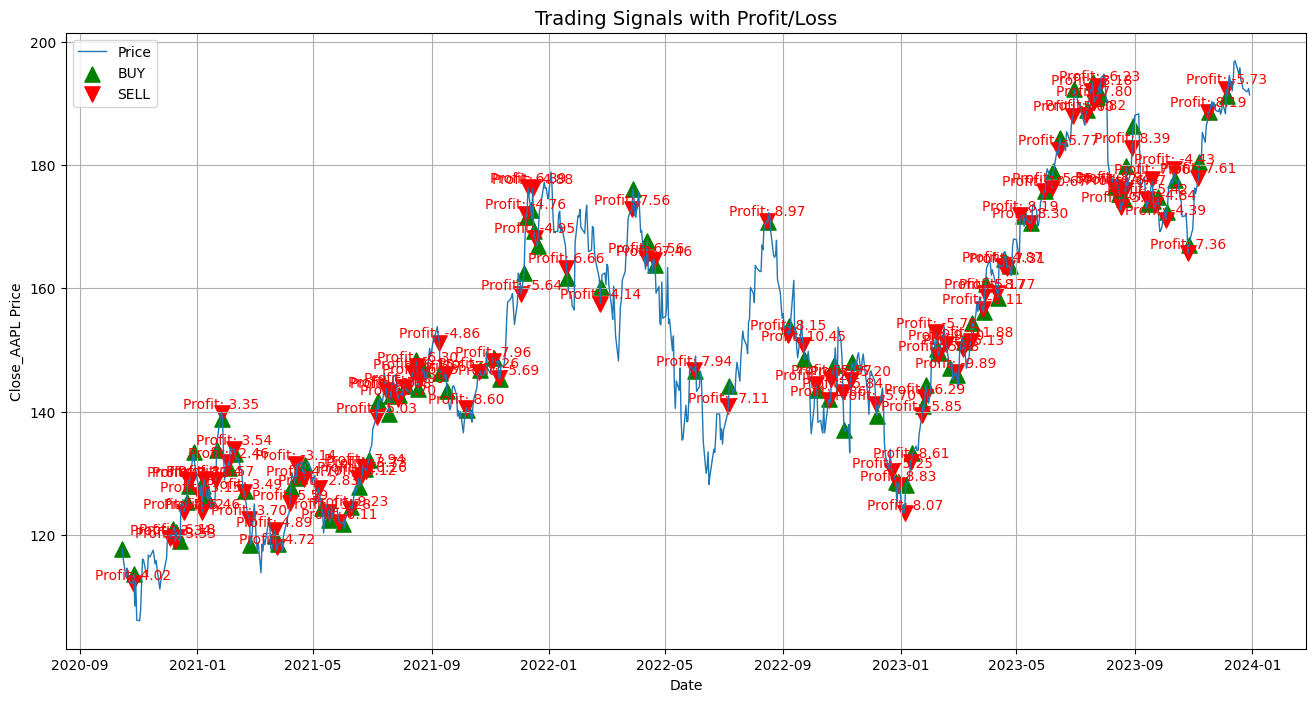

In [ ]:
# 1. Simple RSI calculation (Relative Strength Index)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 2. Generate moving averages (SMA, EMA)
def compute_moving_averages(df, ticker, window_sma=50, window_ema=200):
    df[f'SMA_50_{ticker}'] = df[f'Close_{ticker}'].rolling(window=window_sma).mean()
    df[f'SMA_200_{ticker}'] = df[f'Close_{ticker}'].rolling(window=window_ema).mean()
    df[f'EMA_50_{ticker}'] = df[f'Close_{ticker}'].ewm(span=window_sma, adjust=False).mean()
    df[f'EMA_200_{ticker}'] = df[f'Close_{ticker}'].ewm(span=window_ema, adjust=False).mean()

# 3. Moving Average Convergence Divergence (MACD)
def compute_macd(df, ticker):
    df[f'MACD_{ticker}'] = df[f'Close_{ticker}'].ewm(span=12, adjust=False).mean() - df[f'Close_{ticker}'].ewm(span=26, adjust=False).mean()
    df[f'MACD_signal_{ticker}'] = df[f'MACD_{ticker}'].ewm(span=9, adjust=False).mean()

# 4. Bollinger Bands (BB)
def compute_bollinger_bands(df, ticker, window=20):
    df[f'BB_middle_{ticker}'] = df[f'Close_{ticker}'].rolling(window=window).mean()
    df[f'BB_upper_{ticker}'] = df[f'BB_middle_{ticker}'] + (df[f'Close_{ticker}'].rolling(window=window).std() * 2)
    df[f'BB_lower_{ticker}'] = df[f'BB_middle_{ticker}'] - (df[f'Close_{ticker}'].rolling(window=window).std() * 2)

# 5. Average True Range (ATR)
def compute_atr(df, ticker, window=14):
    df[f'H-L_{ticker}'] = df[f'High_{ticker}'] - df[f'Low_{ticker}']
    df[f'H-PC_{ticker}'] = abs(df[f'High_{ticker}'] - df[f'Close_{ticker}'].shift())
    df[f'L-PC_{ticker}'] = abs(df[f'Low_{ticker}'] - df[f'Close_{ticker}'].shift())
    df[f'TR_{ticker}'] = df[[f'H-L_{ticker}', f'H-PC_{ticker}', f'L-PC_{ticker}']].max(axis=1)
    df[f'ATR_{ticker}'] = df[f'TR_{ticker}'].rolling(window=window).mean()

# 6. Log Returns (Price changes over time)
def compute_log_returns(df, ticker):
    df[f'log_returns_{ticker}'] = np.log(df[f'Close_{ticker}'] / df[f'Close_{ticker}'].shift(1))

# 7. Price-related features: Volatility and Change
def compute_volatility_and_change(df, ticker, window=20):
    df[f'returns_{ticker}'] = df[f'Close_{ticker}'].pct_change()
    df[f'volatility_{ticker}'] = df[f'returns_{ticker}'].rolling(window=window).std()
    df[f'price_change_{ticker}'] = df[f'Close_{ticker}'].pct_change() * 100

def generate_numerical_features(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise KeyError("The DataFrame must have a datetime index named 'Date'.")

    tickers = ['AAPL', 'GOOGL', 'MSFT']

    for ticker in tickers:
        compute_moving_averages(df, ticker)
        df[f'RSI_{ticker}'] = compute_rsi(df[f'Close_{ticker}'])
        compute_macd(df, ticker)
        compute_bollinger_bands(df, ticker)
        compute_atr(df, ticker)
        compute_log_returns(df, ticker)
        compute_volatility_and_change(df, ticker)

    # Drop rows with NaN values due to rolling window calculations
    df = df.dropna()

    return df

market_data_df = market_data.fetch_data()

# Generate numerical features from market data
try:
    numerical_features_df = generate_numerical_features(market_data_df.copy())
    print(f"Number of features: {numerical_features_df.shape[1]}")
except KeyError as e:
    print(e)
    raise

model = sb3.DDPG.load("main_trained_trading_model")

if isinstance(econ_data, np.ndarray):
    econ_data = econ_data[:len(market_data_df)]
    econ_data = np.pad(econ_data, ((0, max(0, len(market_data_df) - len(econ_data))), (0, 0)), mode='edge')
    econ_data = pd.DataFrame(econ_data, index=market_data_df.index)

econ_data = econ_data.reindex(numerical_features_df.index, method='ffill')

class TradingEnv(gym.Env):
    def __init__(self, data, sentiment_data=None, econ_data=None):
        super(TradingEnv, self).__init__()
        self.data = data
        self.sentiment_data = sentiment_data
        self.econ_data = econ_data

        self._align_data()

        self.current_step = 0

        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(5,),
            dtype=np.float32
        )

        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

    def _align_data(self):
        if self.sentiment_data is not None:
            self.sentiment_data = np.interp(
                np.linspace(0, 1, len(self.data)),
                np.linspace(0, 1, len(self.sentiment_data)),
                self.sentiment_data
            ).tolist()

        if self.econ_data is not None and isinstance(self.econ_data, pd.DataFrame):
            self.econ_data = self.econ_data.reindex(self.data.index, method='ffill')

    def step(self, action):
        observation = self.data.iloc[self.current_step].values[:5]
        profit_loss = np.dot(observation, action)
        reward = profit_loss - np.mean(self.data.iloc[max(0, self.current_step-10):self.current_step+1].values[:, :5])

        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        return observation, reward, done, {}

    def reset(self):
        self.current_step = 0
        return self.data.iloc[self.current_step].values[:5]  # Trim to 5 features

# Prepare the environment with the trained model
env = DummyVecEnv([lambda: TradingEnv(numerical_features_df, sentiment_data, econ_data)])

# Mapping function to handle scalar actions
def map_action_to_signal(action_scalar, close_prices, current_index):
    print(f"Step {current_index}: Action Scalar = {action_scalar}")

    if action_scalar > 0.5:
        return "BUY"
    elif action_scalar < -0.5:
        return "SELL"
    else:
        return "HOLD"

# Enhanced Position Manager class
class PositionManager:
    def __init__(self, profit_target=0.05, stop_loss=-0.03):
        self.current_position = "CASH"
        self.entry_price = None
        self.profit_target = profit_target
        self.stop_loss = stop_loss

    def update_position(self, signal, current_price):
        if self.current_position == "HOLD":
            unrealized_profit = (current_price - self.entry_price) / self.entry_price
            if unrealized_profit >= self.profit_target:
                return self._close_position(current_price, "PROFIT")
            elif unrealized_profit <= self.stop_loss:
                return self._close_position(current_price, "LOSS")

        if signal == "BUY" and self.current_position == "CASH":
            self.current_position = "HOLD"
            self.entry_price = current_price
            return "BUY"
        elif signal == "SELL" and self.current_position == "HOLD":
            return self._close_position(current_price, "MANUAL SELL")
        return "HOLD"

    def _close_position(self, current_price, reason):
        profit = current_price - self.entry_price
        self.current_position = "CASH"
        self.entry_price = None
        return f"SELL ({reason}: {profit:.2f})"

# Prediction function
def predict_trading_signals(market_data_df, numerical_features_df):
    obs = env.reset()
    signals = []
    position_manager = PositionManager()
    tickers = ['AAPL', 'GOOGL', 'MSFT']

    for i in range(len(numerical_features_df)):
        # Ensure observation is in the correct shape (5 features,)
        observation = numerical_features_df.iloc[i].values[:5].reshape(1, -1)

        action, _ = model.predict(observation, deterministic=True)
        action_scalar = action[0][0]

        raw_signal = map_action_to_signal(action_scalar, market_data_df[f'Close_{tickers[0]}'], i)

        executed_signal = position_manager.update_position(raw_signal, market_data_df[f'Close_{tickers[0]}'].iloc[i])

        signals.append(executed_signal)

        obs, _, _, _ = env.step(action)

        print(f"Step {i}: Action={action_scalar:.2f} | Signal={executed_signal} | Price={market_data_df[f'Close_{tickers[0]}'].iloc[i]:.2f}")

    return signals

signals = predict_trading_signals(market_data_df, numerical_features_df)

predicted_signals_df = pd.DataFrame({
    'Signal': signals
}, index=numerical_features_df.index[:len(signals)])

predicted_signals_df['Price'] = market_data_df[f'Close_AAPL'].reindex(predicted_signals_df.index)

# Enhanced plotting with profit annotations
def plot_trading_signals(signals_df, close_col):
    plt.figure(figsize=(16, 8))
    plt.plot(signals_df.index, signals_df['Price'], label='Price', lw=1)

    buy_mask = signals_df['Signal'].str.contains("BUY")
    sell_mask = signals_df['Signal'].str.contains("SELL")

    # Plot BUY signals
    plt.scatter(
        signals_df[buy_mask].index,
        signals_df[buy_mask]['Price'],
        color='green', marker='^', s=120, label='BUY'
    )

    # Plot SELL signals
    plt.scatter(
        signals_df[sell_mask].index,
        signals_df[sell_mask]['Price'],
        color='red', marker='v', s=120, label='SELL'
    )

    for idx, row in signals_df[sell_mask].iterrows():
        profit_loss = float(row['Signal'].split(': ')[1][:-1])
        plt.text(
            row.name, row['Price'] * 1.005,
            f"Profit: {profit_loss:.2f}",
            ha='center', color='red', fontsize=10
        )

    plt.title("Trading Signals with Profit/Loss", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel(f"{close_col} Price")
    plt.legend()
    plt.grid(True)

    plt.show()

plot_trading_signals(predicted_signals_df, 'Close_AAPL')

/usr/local/lib/python3.11/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


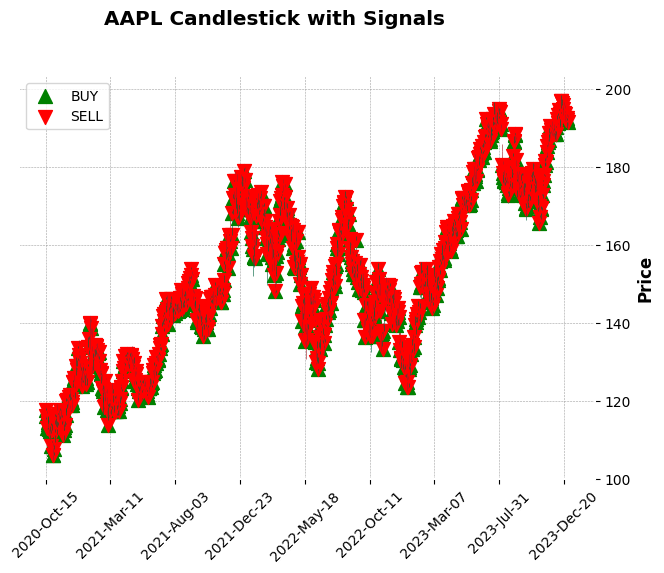

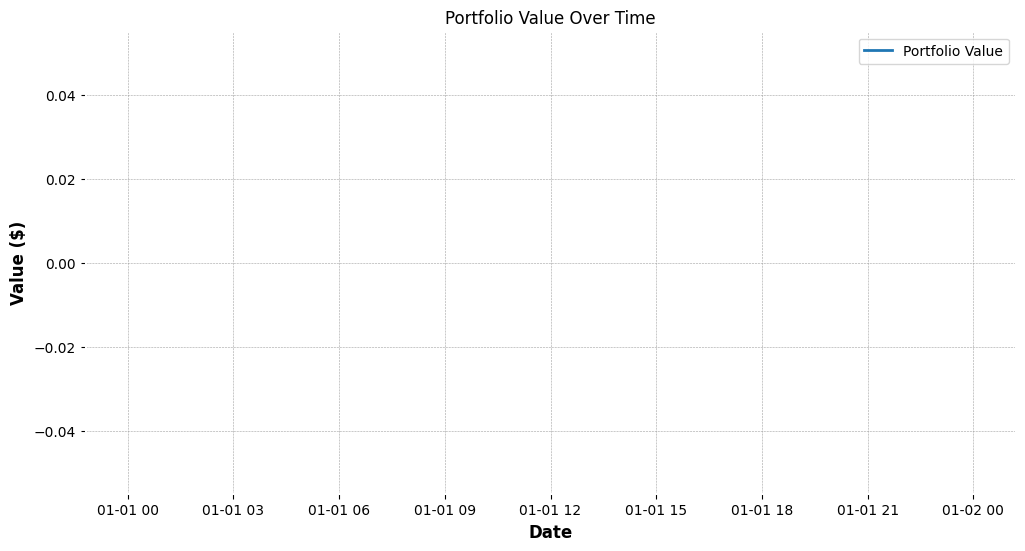

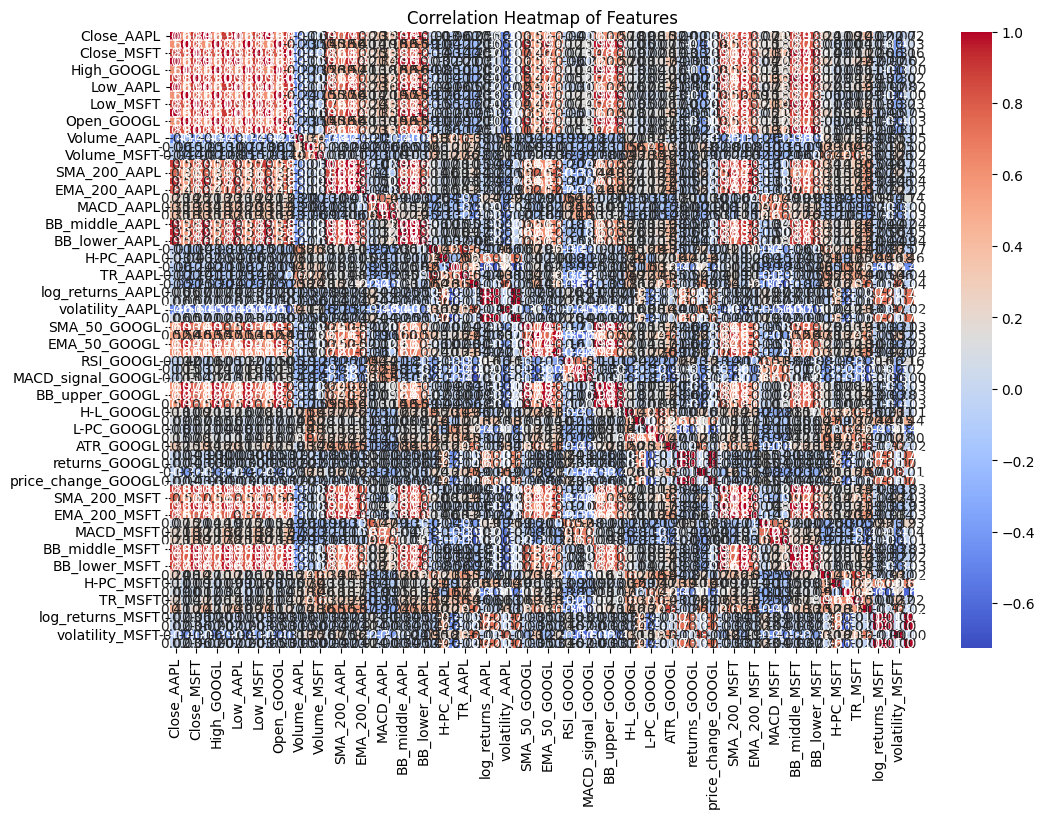

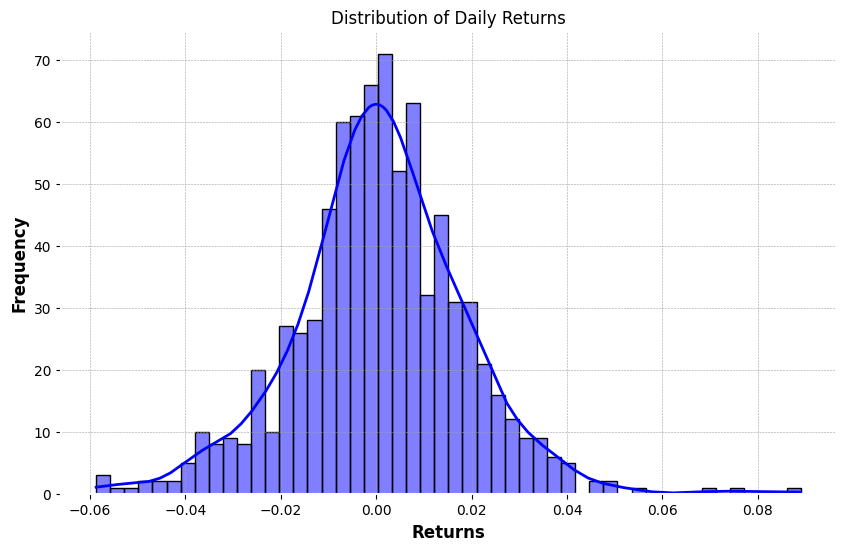

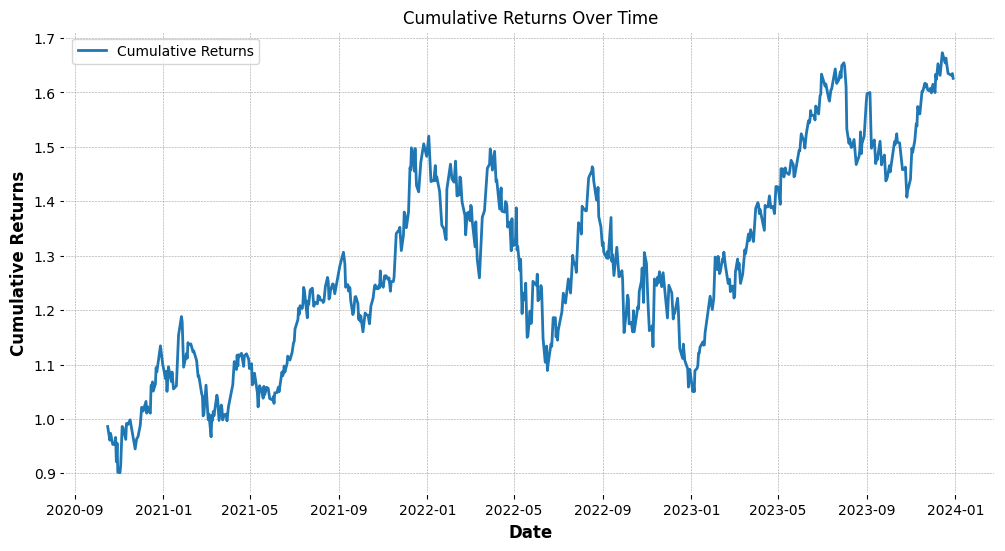

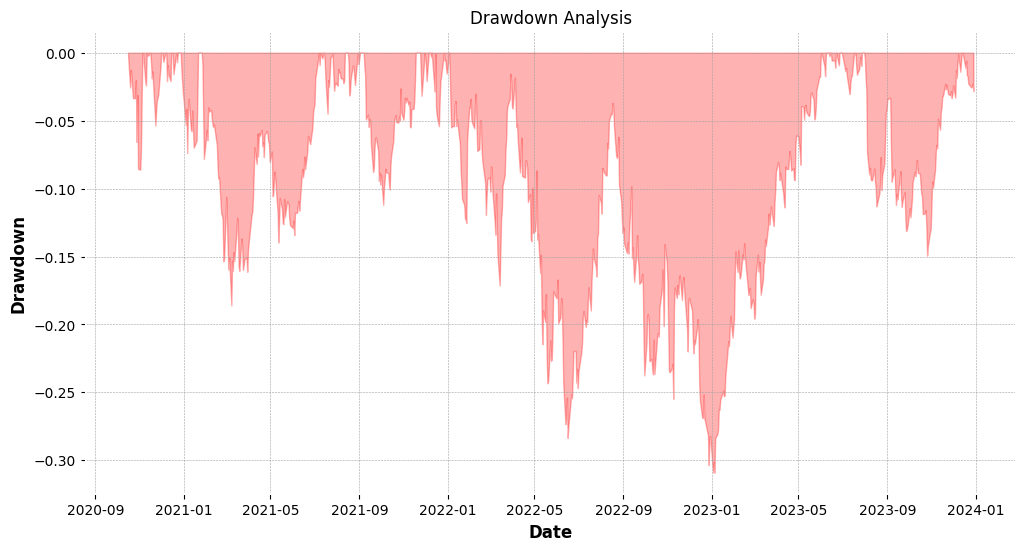

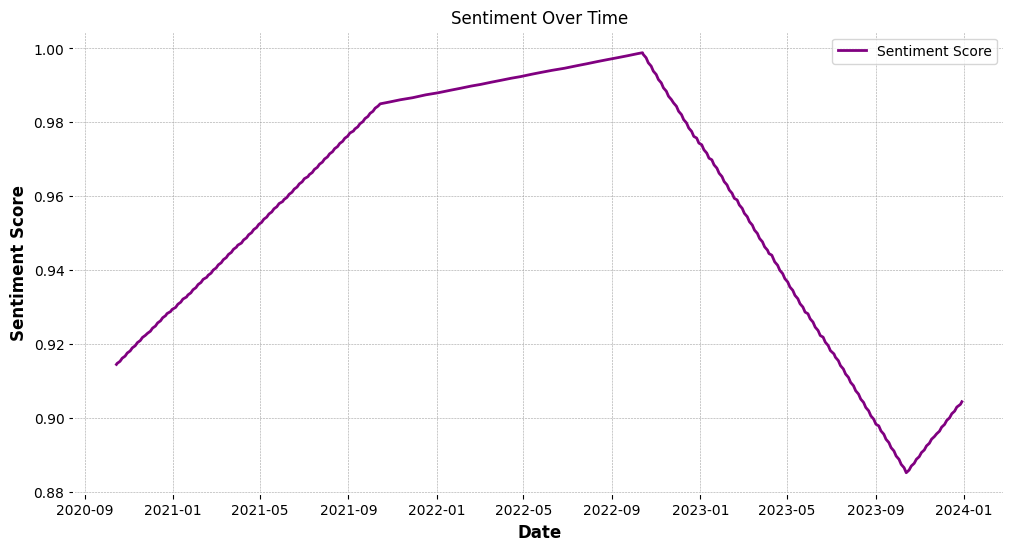

<ipython-input-45-0c1378ef9b7f>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['Profit'] = trades['Signal'].apply(lambda x: float(x.split(': ')[1][:-1]) if "SELL" in x else 0)


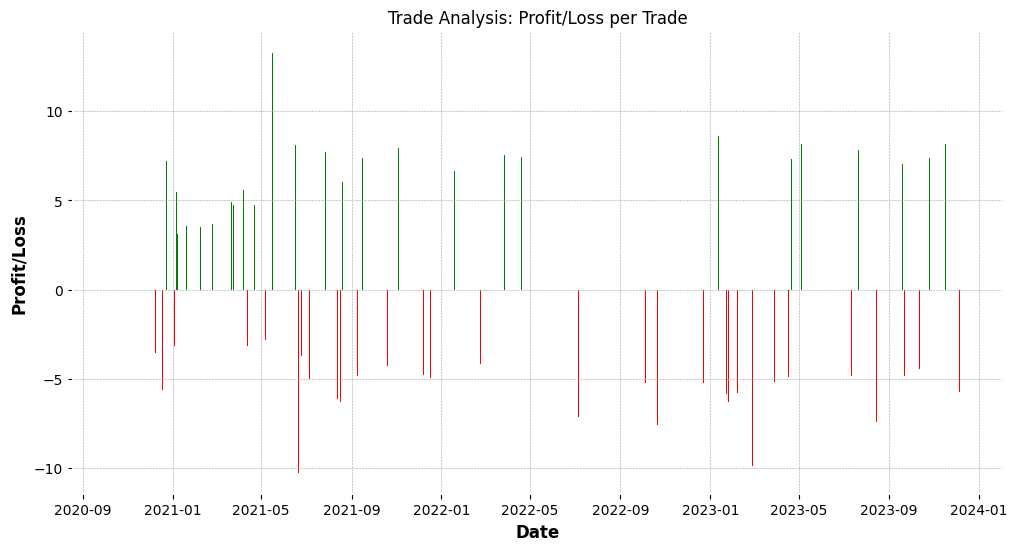

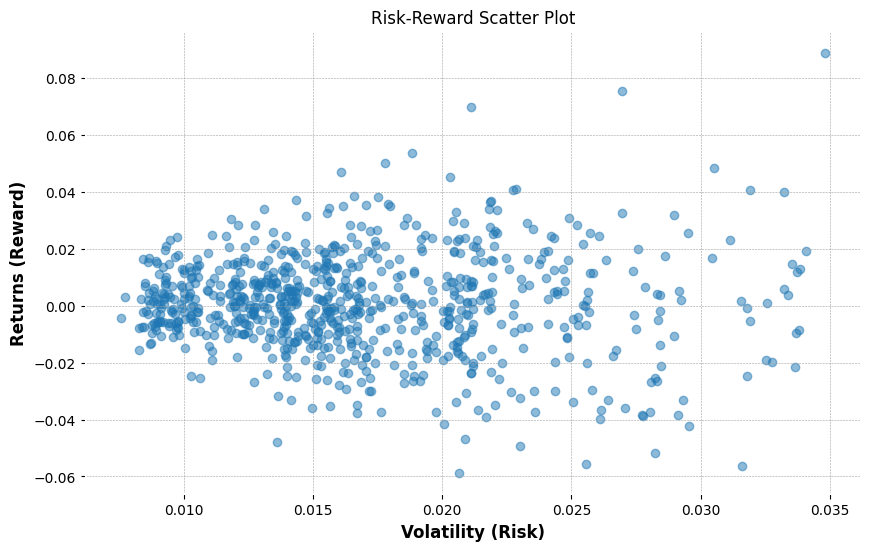

ValueError: x and y must have same first dimension, but have shapes (807,) and (806,)

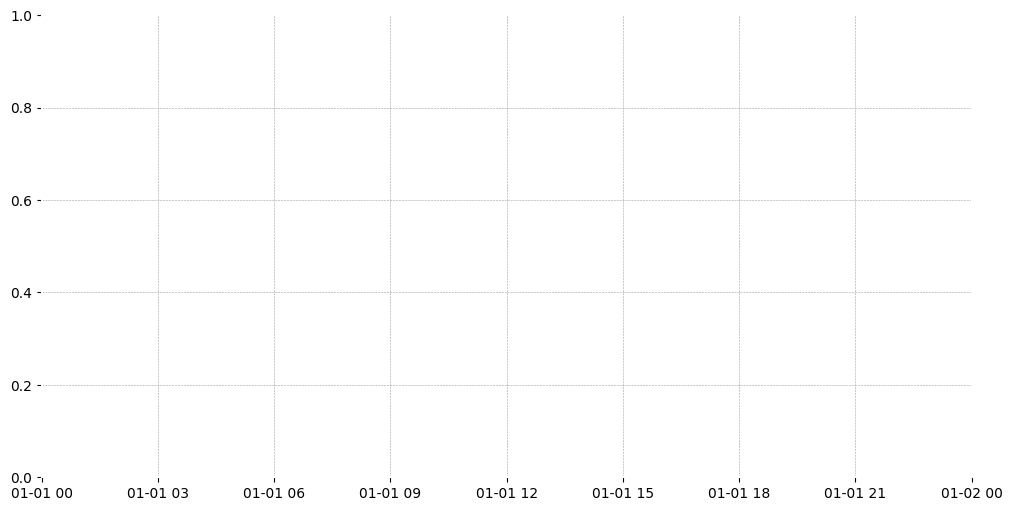

In [ ]:
# 1. Candlestick Chart with Annotations
def plot_candlestick_with_signals(df, signals_df, ticker):
    # Rename columns to match mplfinance format
    df_renamed = df.rename(columns={
        f'Open_{ticker}': 'Open',
        f'High_{ticker}': 'High',
        f'Low_{ticker}': 'Low',
        f'Close_{ticker}': 'Close',
        f'Volume_{ticker}': 'Volume'
    })

    # Add BUY/SELL signals
    apds = [
        mpf.make_addplot(signals_df['Price'], scatter=True, markersize=100, marker='^', color='g', label='BUY'),
        mpf.make_addplot(signals_df['Price'], scatter=True, markersize=100, marker='v', color='r', label='SELL')
    ]

    # Plot candlestick chart
    mpf.plot(df_renamed, type='candle', addplot=apds, style='charles', title=f"{ticker} Candlestick with Signals")

# 2. Portfolio Value Over Time
def plot_portfolio_value(signals_df, initial_investment=10000):
    portfolio_value = [initial_investment]
    for i, signal in enumerate(signals_df['Signal']):
        if signal.startswith("BUY"):
            portfolio_value.append(portfolio_value[-1] * (1 + signals_df['Price'].pct_change().iloc[i]))
        elif signal.startswith("SELL"):
            portfolio_value.append(portfolio_value[-1] * (1 - signals_df['Price'].pct_change().iloc[i]))
        else:
            portfolio_value.append(portfolio_value[-1])

    plt.figure(figsize=(12, 6))
    plt.plot(signals_df.index, portfolio_value[1:], label='Portfolio Value', lw=2)
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Date")
    plt.ylabel("Value ($)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 3. Heatmap for Correlation
def plot_correlation_heatmap(df):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Heatmap of Features")
    plt.show()

# 4. Distribution of Returns
def plot_returns_distribution(signals_df):
    returns = signals_df['Price'].pct_change().dropna()
    plt.figure(figsize=(10, 6))
    sns.histplot(returns, kde=True, bins=50, color='blue')
    plt.title("Distribution of Daily Returns")
    plt.xlabel("Returns")
    plt.ylabel("Frequency")
    plt.show()

# 5. Cumulative Returns
def plot_cumulative_returns(signals_df):
    cumulative_returns = (1 + signals_df['Price'].pct_change()).cumprod()
    plt.figure(figsize=(12, 6))
    plt.plot(signals_df.index, cumulative_returns, label='Cumulative Returns', lw=2)
    plt.title("Cumulative Returns Over Time")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid(True)
    plt.show()

# 6. Drawdown Analysis
def plot_drawdown(signals_df):
    cumulative_returns = (1 + signals_df['Price'].pct_change()).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    plt.figure(figsize=(12, 6))
    plt.fill_between(signals_df.index, drawdown, color='red', alpha=0.3)
    plt.title("Drawdown Analysis")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.grid(True)
    plt.show()

# 7. Sentiment Over Time
def plot_sentiment_over_time(sentiment_data, signals_df):
    plt.figure(figsize=(12, 6))
    plt.plot(signals_df.index, sentiment_data[:len(signals_df)], label='Sentiment Score', color='purple')
    plt.title("Sentiment Over Time")
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# 8. Trade Analysis
def plot_trade_analysis(signals_df):
    trades = signals_df[signals_df['Signal'].str.contains("BUY|SELL")]
    trades['Profit'] = trades['Signal'].apply(lambda x: float(x.split(': ')[1][:-1]) if "SELL" in x else 0)
    plt.figure(figsize=(12, 6))
    plt.bar(trades.index, trades['Profit'], color=np.where(trades['Profit'] > 0, 'g', 'r'))
    plt.title("Trade Analysis: Profit/Loss per Trade")
    plt.xlabel("Date")
    plt.ylabel("Profit/Loss")
    plt.grid(True)
    plt.show()

# 9. Risk-Reward Scatter Plot
def plot_risk_reward(signals_df):
    returns = signals_df['Price'].pct_change().dropna()
    volatility = returns.rolling(window=20).std()
    plt.figure(figsize=(10, 6))
    plt.scatter(volatility, returns, alpha=0.5)
    plt.title("Risk-Reward Scatter Plot")
    plt.xlabel("Volatility (Risk)")
    plt.ylabel("Returns (Reward)")
    plt.grid(True)
    plt.show()

# 10. Rolling Sharpe Ratio
def plot_rolling_sharpe(signals_df, risk_free_rate=0.01):
    returns = signals_df['Price'].pct_change().dropna()
    rolling_sharpe = (returns.rolling(window=20).mean() - risk_free_rate) / returns.rolling(window=20).std()
    plt.figure(figsize=(12, 6))
    plt.plot(signals_df.index, rolling_sharpe, label='Rolling Sharpe Ratio', lw=2)
    plt.title("Rolling Sharpe Ratio Over Time")
    plt.xlabel("Date")
    plt.ylabel("Sharpe Ratio")
    plt.legend()
    plt.grid(True)
    plt.show()

# 11. Word Cloud for Sentiment
def plot_sentiment_wordcloud(news_articles):
    text = " ".join([article['title'] for article in news_articles])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Sentiment Word Cloud")
    plt.show()

# 12. Monte Carlo Simulations
def monte_carlo_simulation(signals_df, num_simulations=1000, days=252):
    returns = signals_df['Price'].pct_change().dropna()
    simulations = np.zeros((days, num_simulations))
    for i in range(num_simulations):
        simulations[:, i] = returns.sample(days, replace=True).cumsum()
    plt.figure(figsize=(12, 6))
    plt.plot(simulations, lw=1, alpha=0.1)
    plt.title("Monte Carlo Simulations of Portfolio Returns")
    plt.xlabel("Days")
    plt.ylabel("Simulated Returns")
    plt.grid(True)
    plt.show()


def run_all_visualizations(market_data_df, predicted_signals_df, numerical_features_df, sentiment_data, news_articles, ticker='AAPL'):
    predicted_signals_df = predicted_signals_df.reindex(market_data_df.index, method='ffill')
    predicted_signals_df = predicted_signals_df.dropna()

    market_data_df = market_data_df.reindex(predicted_signals_df.index)

    plot_candlestick_with_signals(market_data_df, predicted_signals_df, ticker)
    plot_portfolio_value(predicted_signals_df)
    plot_correlation_heatmap(numerical_features_df)
    plot_returns_distribution(predicted_signals_df)
    plot_cumulative_returns(predicted_signals_df)
    plot_drawdown(predicted_signals_df)
    plot_sentiment_over_time(sentiment_data, predicted_signals_df)
    plot_trade_analysis(predicted_signals_df)
    plot_risk_reward(predicted_signals_df)
    plot_rolling_sharpe(predicted_signals_df)
    plot_sentiment_wordcloud(news_articles)
    monte_carlo_simulation(predicted_signals_df)

run_all_visualizations(market_data_df, predicted_signals_df, numerical_features_df, sentiment_data, news_articles, ticker='AAPL')

In [ ]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_risk_reward_time(signals_df):
    """
    Creates a 3D scatter plot to visualize risk, reward, and time.

    Parameters:
        signals_df (pd.DataFrame): DataFrame containing 'Price' and 'Date' columns.
    """
    # Ensure 'Price' column exists
    if 'Price' not in signals_df.columns:
        raise ValueError("signals_df must contain a 'Price' column.")

    # Calculate daily returns and volatility
    returns = signals_df['Price'].pct_change().dropna()
    volatility = returns.rolling(window=20).std()  # 20-day rolling volatility

    # Drop NaN values from volatility (due to rolling window)
    volatility = volatility.dropna()
    returns = returns[returns.index.isin(volatility.index)]

    # Ensure data alignment
    if len(returns) != len(volatility) or len(returns) != len(signals_df.loc[volatility.index]):
        raise ValueError("Data lengths do not match after alignment.")

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot risk (volatility), reward (returns), and time (dates)
    ax.scatter(
        volatility,  # X-axis: Risk (Volatility)
        returns,     # Y-axis: Reward (Returns)
        range(len(volatility)),  # Z-axis: Time (Index of dates)
        c=returns,   # Color points by returns
        cmap='viridis',  # Color map
        alpha=0.7
    )

    # Add labels and title
    ax.set_xlabel("Risk (Volatility)")
    ax.set_ylabel("Reward (Returns)")
    ax.set_zlabel("Time (Days)")
    ax.set_title("3D Risk-Reward-Time Visualization")

    # Add color bar
    cbar = fig.colorbar(ax.scatter(volatility, returns, range(len(volatility)), c=returns, cmap='viridis'))
    cbar.set_label("Returns")

    plt.show()

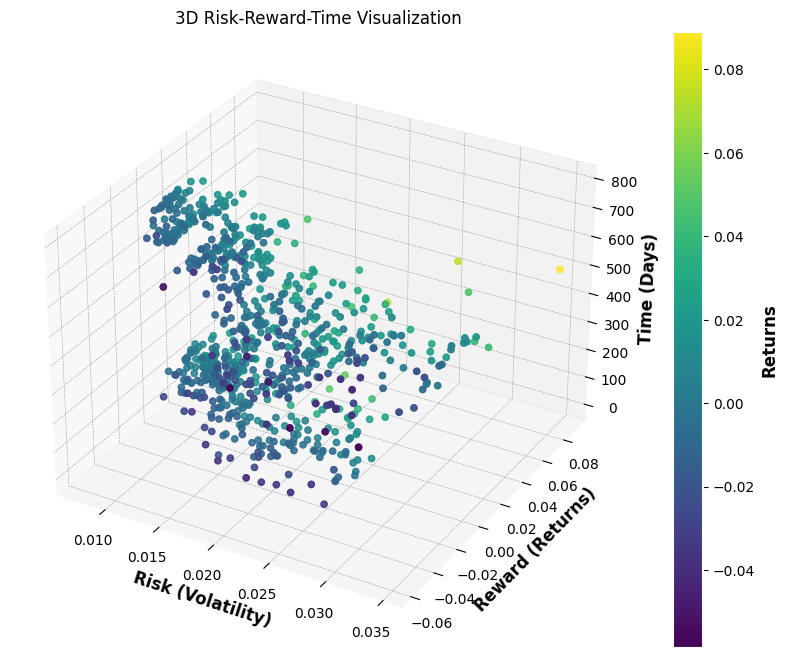

In [ ]:
plot_3d_risk_reward_time(predicted_signals_df)

In [ ]:
print(Solution().minOperation([31,38 ,23 ,22, 6, 46, 50]))

59
